In [1]:
# Using Garcia's relax program to solve for potential inside a Faraday cage

In [2]:
# Set up configuration options and special features
from pylab import *
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def dinput(input_text) :
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))

In [4]:
def Phi_anal(x,y,nmax,Phi0,Lx,Ly) : # analytic potential
    Phi = 0
    for n in range(1,nmax,2) : # odd values of n
            Phi += sin(n*pi*x/Lx)*sinh(n*pi*y/Lx) / sinh(n*pi*Ly/Lx) / n
    Phi *= 4.0*Phi0/pi
    return Phi

In [5]:
#* Initialize parameters (system size, grid spacing, etc.)
method = dinput('Choose numerical method: 0) analytic; 1) Jacobi; 2) Gauss-Seidel; 3) SOR ')
N = dinput('Enter number of grid points on a side: ')
L = 1             # System size (length)
dr = L/(N-1)      # Grid spacing
x = arange(N)*dr  # x coordinate
y = arange(N)*dr  # y coordinate

#* Select over-relaxation factor (SOR only)
if method == 3 :
    omegaOpt = 2/(1+sin(pi/N))    # Theoretical optimum
    print('Theoretical optimum omega = ', omegaOpt)
    omega = finput('Enter desired omega: ')

Choose numerical method: 0) analytic; 1) Jacobi; 2) Gauss-Seidel; 3) SOR 3
Enter number of grid points on a side: 60
Theoretical optimum omega =  1.9005337488803598
Enter desired omega: 1.9


In [8]:
#* Set initial guess as first term in separation of variables soln.
phi0 = 1      # Potential at y=L
phi = empty((N,N))
for i in range(N) :
    for j in range(N) : # we could partially vectorize this loop as in the next cell
        phi[i,j] = phi0 * 4/(pi*sinh(pi)) * sin(pi*x[i]/L)*sinh(pi*y[j]/L)  

#* Set boundary conditions
# phi[0,:] = 0
# phi[-1,:] = 0
# phi[:,0] = phi0*ones(N)
# phi[:,-1] = phi0*ones(N)

phi[:,0] = np.arange(0,N,1) # top wall
phi[:,-1] = np.arange(0,N,1) # bottom wall
phi[0,:] = 0 #  wall
phi[-1,:] = 100 #  wall

phi = rot90(phi, k =1)

print('Potential at y=L and x=L equals',phi0)
print('Potential is zero on all other boundaries')

Potential at y=L and x=L equals 1
Potential is zero on all other boundaries


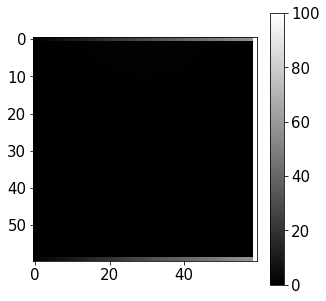

In [9]:
figure(figsize=(5,5))
imshow(phi, cmap ='gray')
colorbar()
show()

In [10]:
square_pos = [(19, 19), (19, 29), (19, 39), (29, 19), (29, 39), (39, 19), (39, 29), (39, 39)]
diamond_pos = [(19,29),(29,19),(29, 39),(39,29)]
triangle_pos = [(29,39), (19,29), (29, 19)]
fine_square_pos = [(24,19), (34,19), (19,24), (19,34), (24,39), (34,39), (39, 24), (39, 34), (19, 19), (19, 29), (19, 39), (29, 19), (29, 39), (39, 19), (39, 29), (39, 39)]

In [11]:
cage = ones((N, N))
for pos in fine_square_pos:
    cage[pos] = 0

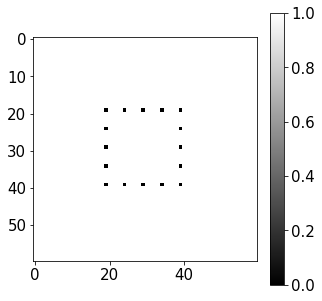

In [12]:
figure(figsize=(5,5))
imshow(cage, cmap = 'gray')
colorbar()
show()

In [13]:
#* Loop until desired fractional change per iteration is obtained
newphi = copy(phi)    # Copy of the solution (used only by Jacobi)
iterMax = N**2           # Set max to avoid excessively long runs
change = ones(iterMax)*NaN
changeDesired = 1e-2    # Stop when the change is given fraction
rho = 2/dr**2
epsilon = 1

print('Desired fractional change = ', changeDesired)

title_text = 'Electrostatic potential $\Phi(x,y)$: '
if method == 0 : ## analytic solution ##
    nmax = 201 # 11, 21, 201
    title_text += 'analytic, $n_\mathrm{max}$=%d' % (nmax)
    for i in range(len(x)) :
        phi[i,:] = Phi_anal(x[i],y,nmax,phi0,L,L)
elif method > 0 : # numerical 
    if method == 1 :
        title_text += 'Jacobi'
    elif method == 2 :
        title_text += 'Gauss$-$Seidel'
    elif method == 3 :
        title_text += 'SOR'
        
for iter in range(iterMax) :
    changeSum = 0
    if method == 0 :
        break
    if method == 1 :      ## Jacobi method ##
        for i in range(1,N-1) :     # Loop over interior points only
            for j in range(1,N-1) :     
                newphi[i,j] = 0.25*( phi[i+1,j] + phi[i-1,j] + 
                                     phi[i,j-1] + phi[i,j+1])
#                 if i == 25 and j == 25: ## point charge
#                     newphi[i,j] += 0.25*( phi[i+1,j] + phi[i-1,j] + 
#                                      phi[i,j-1] + phi[i,j+1] + 2)
                changeSum += abs( 1 - phi[i,j]/newphi[i,j] )
        phi = copy(newphi)   

    elif method == 2 :    ## Gauss-Seidel method ##
        for i in range(1,N-1) :     # Loop over interior points only
            for j in range(1,N-1) :     
                temp = 0.25*( phi[i+1,j] + phi[i-1,j] + 
                              phi[i,j-1] + phi[i,j+1] )
                changeSum += abs( 1 - phi[i,j]/temp )
                phi[i,j] = temp

    else :                ## SOR method ##    
        for i in range(1,N-1) :     # Loop over interior points only
            for j in range(1,N-1) :     
                temp = 0.25*omega*( phi[i+1,j] + phi[i-1,j] + 
                                    phi[i,j-1] + phi[i,j+1] ) + (1-omega)*phi[i,j]            
                changeSum += abs( 1 - phi[i,j]/temp )
                phi[i,j] = cage[i,j]*temp

    #* Check if fractional change is small enough to halt the iteration
    change[iter] = changeSum/(N-2)**2
    if (iter+1) % 10 < 1 :
        print('After ', iter+1, ' iterations, fractional change = ', change[iter])

    if change[iter] < changeDesired : 
        print('Desired accuracy achieved after ', iter+1, ' iterations')
        print('Breaking out of main loop')
        break
        
title_text += ', $N_\mathrm{iter} = %d$' % (iter+1)

Desired fractional change =  0.01
After  10  iterations, fractional change =  0.1673152822187535
After  20  iterations, fractional change =  0.06642663170499209
After  30  iterations, fractional change =  0.03748681245676382
After  40  iterations, fractional change =  0.026391436377343997
After  50  iterations, fractional change =  0.03111587348707764
After  60  iterations, fractional change =  0.058001368904018455
After  70  iterations, fractional change =  0.029574117260540718
After  80  iterations, fractional change =  0.018948512409119957
After  90  iterations, fractional change =  0.01218418760381949
Desired accuracy achieved after  95  iterations
Breaking out of main loop


In [12]:
# np.savetxt('square.txt', phi)
# np.savetxt('diamond.txt', phi)
# np.savetxt('triangle.txt', phi)
# np.savetxt('fine_square.txt', phi)


In [14]:
rcParams.update({'font.size': 20})

Text(0.5, 1.0, 'Electrostatic potential $\\Phi(x,y)$: SOR, $N_\\mathrm{iter} = 95$')

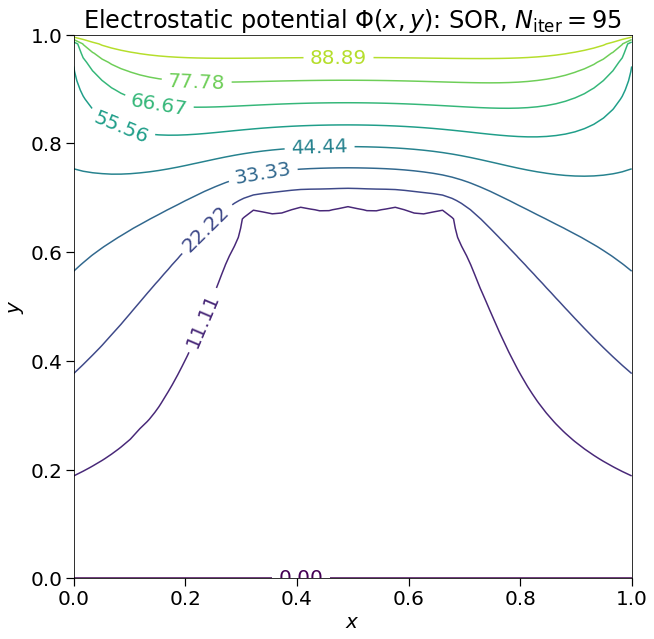

In [15]:
#* Plot final estimate of potential as a contour plot
fig1 = figure(figsize=(10,10))
# levels = linspace(0, 1, 11)
levels = linspace(0, 100, 10)

ct = contour(x, y, flipud(rot90(phi)), levels) 
clabel(ct, fmt='%1.2f') 
xlabel('$x$')
ylabel('$y$')
#title('Potential after %g iterations' % iter)
tick_params('both', length=8, width=1.2, which='major') # bigger axis ticks
title(title_text)
#savefig('relax_fig1.png')

In [16]:
rcParams.update({'font.size': 15})

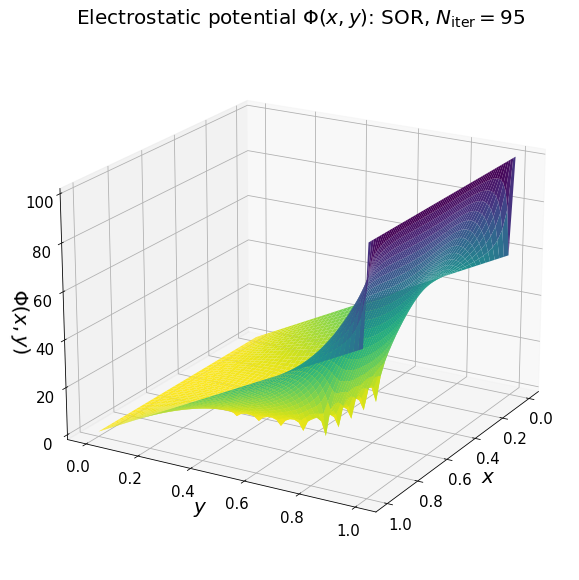

In [48]:
#* Plot final estimate of potential as contour and surface plots

fig2 = figure(figsize=(10,10))
ax = fig2.gca(projection = '3d')
Xp, Yp = np.meshgrid(x, y)
ax.plot_surface(Xp, Yp, flipud(rot90(phi)), rstride=1, cstride=1, cmap=cm.viridis_r)
ax.view_init(elev=20, azim=30)
ax.set_xlabel('$x$',fontsize=20)
ax.set_ylabel('$y$',fontsize=20)
ax.set_zlabel('$\Phi(x,y)$',fontsize=20)
title(title_text,fontsize=20)
show()
#savefig('relax_fig2.png')

In [17]:
rcParams.update({'font.size': 20})

In [21]:
phi_square = np.loadtxt('square.txt')
phi_diamond = np.loadtxt('diamond.txt')
phi_triangle = np.loadtxt('triangle.txt')
phi_finesquare = np.loadtxt('fine_square.txt')

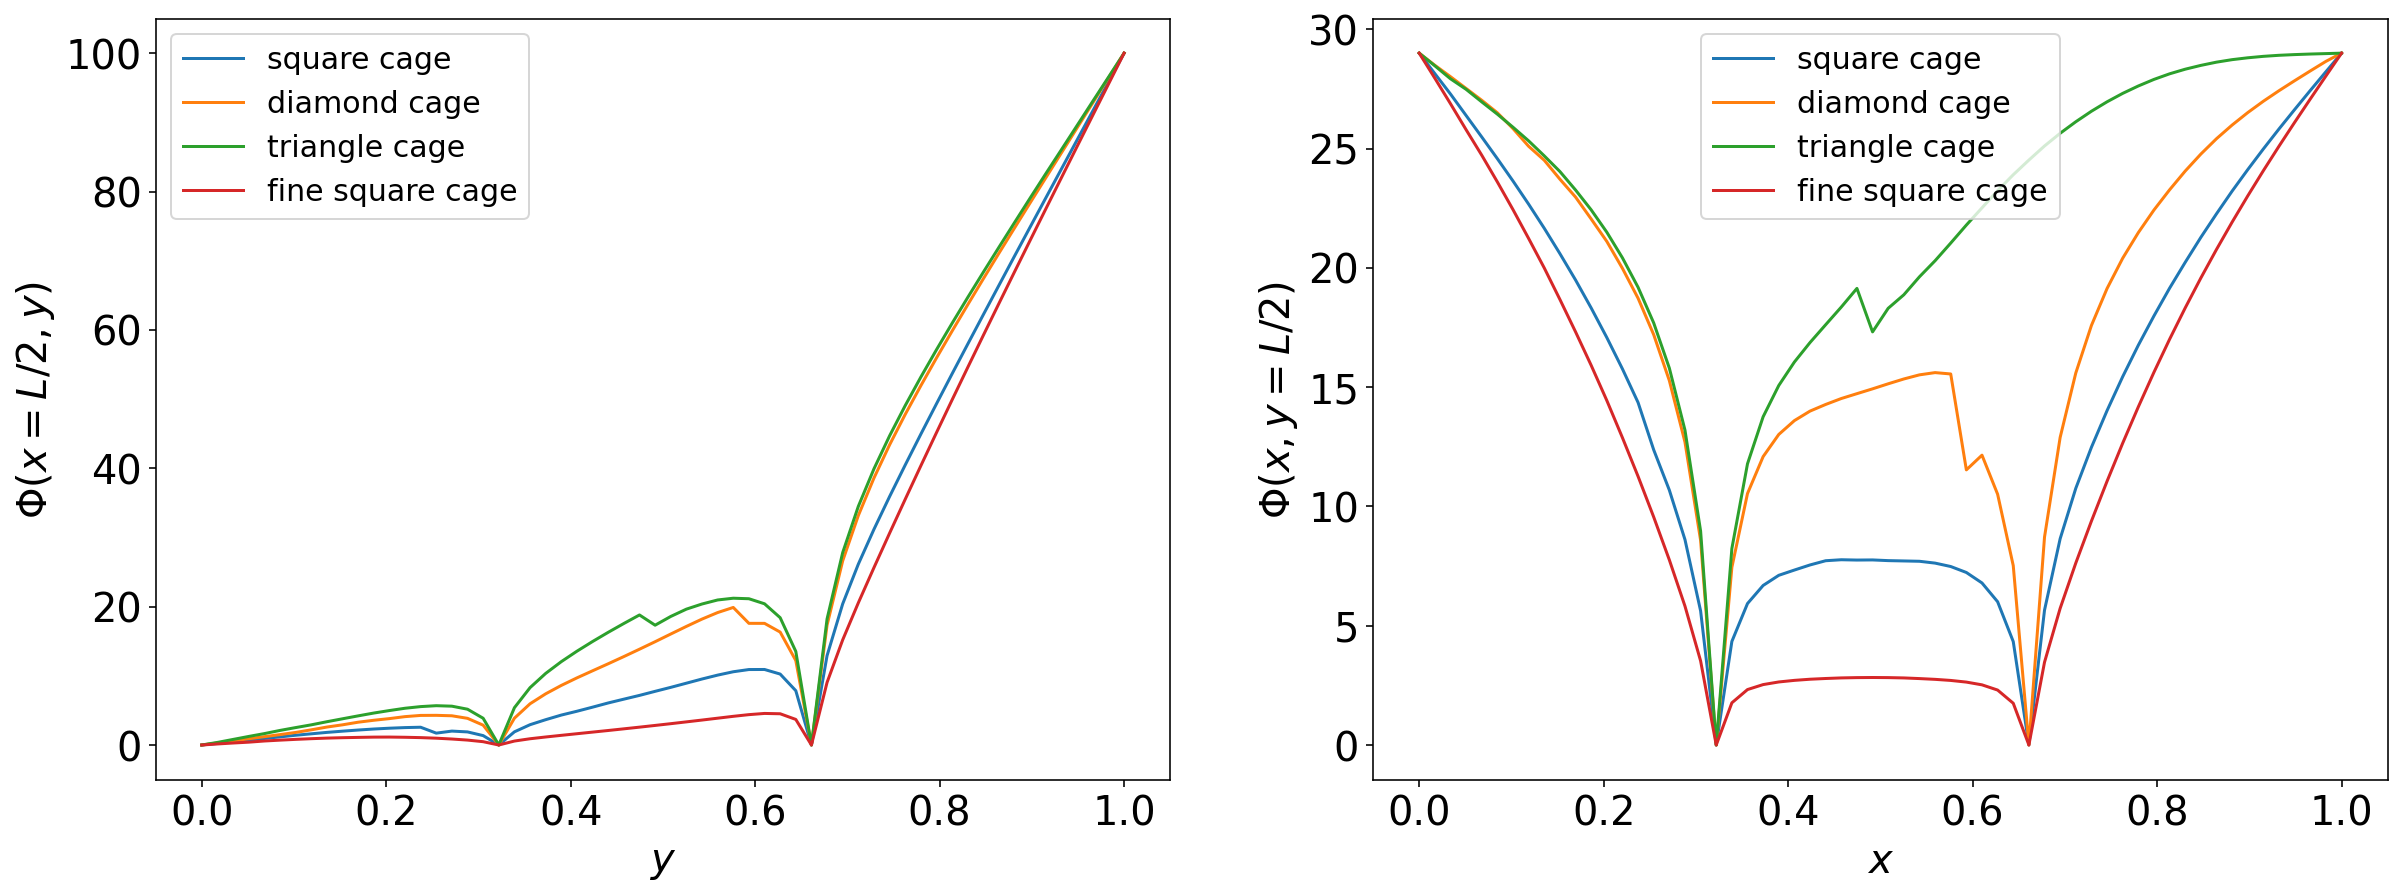

In [27]:
figure(figsize=(20,7))

subplot(1,2,1)
plot(y, phi_square[29,:], label = 'square cage')
plot(y, phi_diamond[29,:], label = 'diamond cage')
plot(y, phi_triangle[29,:], label = 'triangle cage')
plot(y, phi_finesquare[29,:], label = 'fine square cage')
legend(fontsize=15)
xlabel('$y$')
ylabel('$\Phi(x =L/2, y)$')

subplot(1,2,2)
plot(x, phi_square[:,29], label = 'square cage')
plot(x, phi_diamond[:,29], label = 'diamond cage')
plot(x, phi_triangle[:,29], label = 'triangle cage')
plot(x, phi_finesquare[:,29], label = 'fine square cage')

legend(fontsize=15)
xlabel('$x$')
ylabel('$\Phi(x, y=L/2)$')
show()

In [20]:
# if method > 0 :
#     fig3 = figure(figsize=(10,7))
#     semilogy(range(1,iter),change[:iter-1])
#     xlabel('iterations')
#     ylabel('$\Delta \Phi$')
#     title(title_text)
#     tick_params('both', length=8, width=1.2, which='major') # bigger axis ticks
#     tick_params('both', length=4, width=1.2, which='minor') # bigger axis ticks
#     #savefig('relax_fig3.png')